#                                    Hotel Recommendation System Modeling Challenge
###### Submitted by Shruti Jadon
                                           

##### The aim of this challenge is to predict the next hotel which is not present in user's history
                    Users.txt : consisiting of user's features, userid, gender, continent
                    Activity.txt: consisting of userid, and hotel selected
                    Hotel.txt: consisiting of hotel number, and rating

##### Requirements:  Python 2.7 and above, Numpy, csv, Pandas,XGBoost
##### Results is in output.csv, consisting of user's next prediction, and in output2.csv is user's next up to 5 prediction.
Important Points:
Model finalized: XGBoost Classifier 

Experimented with Rule Based Approach, RandomForest, KNN(not good accuracy, optimal neighbor=1), Two Layer Neural Network(even with 100 epochs, it was giving 2% less than XGBoost, perhaps with more layers it would have worked, but then again the issue was, that we have less number of paramters, there could be a case of overfitting if we go for parametric machine learning approach).

Experimented with hybrid method which will return the hotel present in both most frequent + Machine Learning output. Didn't give good results.


##### First Step is to read through data and see what kind of values are present in data.

In [1]:
import numpy as np
from collections import defaultdict
import csv
import numpy as np
import matplotlib.pyplot as plt

temp_dict={}
with open('Input/users.txt') as f: # here we saw that, user.txt have string categorical data, so have been encoded,
    next(f)                  # we can also do this via using scikit learn, or pandas, but for simplicity, it has been done here.
    for lines in f:
        line=lines.split()
        if line[2]=='female':
            line[2]=1
        else:
            line[2]=0
        line=list(map(int, line))
        temp_dict[line[0]]=line[1:]
        
hotel_dict={}
with open('Input/hotels.txt') as f:
    next(f)
    for lines in f:
        line=lines.split()
        hotel_dict[int(line[0])]=float(line[1])
        
final_data=[]
global_hist={}
with open('Input/activity.txt') as f:
    next(f)
    for lines in f:
        line=lines.split()
        line=list(map(int, line))
        x=[line[0]]+temp_dict[line[0]]+[hotel_dict[line[1]],line[1]] #0:userid, 1:continent, 2:gender, 3:rating, 4:hotel
        if line[0] in global_hist.keys():
            global_hist[line[0]].append(line[1])
        else:
            global_hist[line[0]]=[line[1]]
        final_data.append(x)

#storing data in csv for visualisation purpose, though it's possible to modify here also without storing.
with open("Input/data.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(['userid','continent','gender','rating','hotel'])
    writer.writerows(final_data)
    
#prepared data for Machine Learning Analysis        
Y=[x[4] for x in final_data]
X=[x[:4] for x in final_data]

###                          Second Step is Visulaizations to analyse each feature

In [2]:
# pandas, numpy, matplotlib, seaborn
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
trip_df = pd.read_csv('data.csv')
trip_df.head()

,userid,continent,gender,rating,hotel
0,1,2,1,4.0,39
1,1,2,1,3.0,44
2,2,3,1,4.5,63
3,2,3,1,2.0,2
4,3,1,0,4.0,26


#### Lets Analyze user's chosen hotel and their ratings. Here, We can observe that most frequent(popular) hotel are likely to come to each user's entry. So, Popularity of a hotel plays role in user's chosen hotel

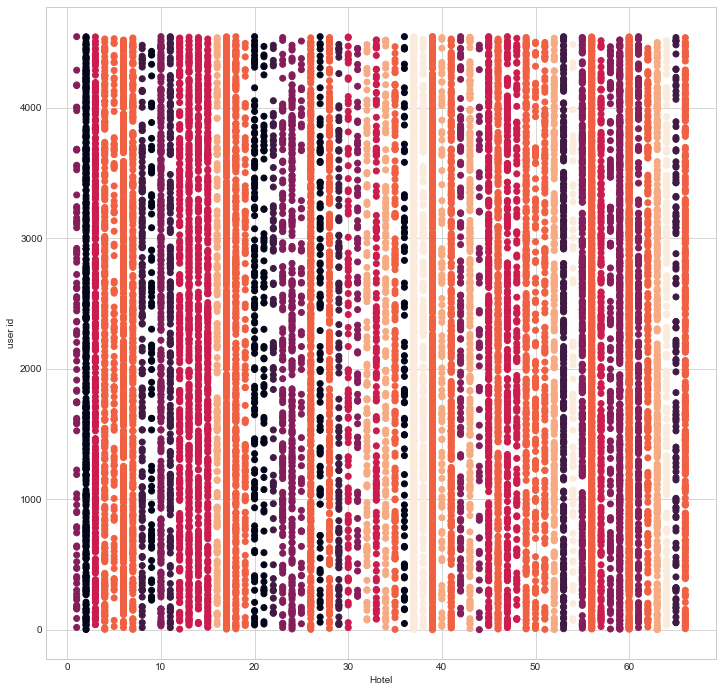

In [3]:
X=np.array(X)
Y=np.array(Y)
N = 50
fig, ax = plt.subplots(figsize=(12,12))
x = Y
y = X[:,0]
colors = X[:,3]
ax.scatter(x, y, c=colors,alpha=10.0)
ax.set_xlabel("Hotel")
ax.set_ylabel("user id")
ax.grid(True)

plt.show()

In [4]:
#next step is to drop userid, as it won't play any role, unless we want to visualize per user.
trip_df = trip_df.drop(['userid'], axis=1)

#### Next step to see if there is a strong correlation among Variables. 

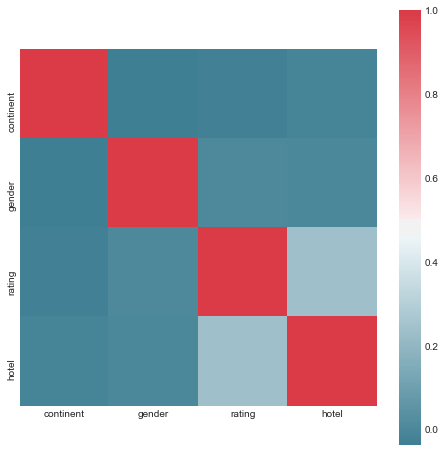

In [5]:
# Let's evaluate correlation among all variables.
f, ax = plt.subplots(figsize=(8, 8))
corr = trip_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


#### Lets explore popular continent and hotel among genders. Here we are visualizing two Bar Plots and determining answers for two questions.
#### What are the most continents one gender travel from?
#### What are the most hotel one gender travel to?
We got results as follows: Gender: Male, Continent: 2, Hotel :56 and Gender: Female, Continent: 2, Hotel :56.

So we can say Gender has no role, in popular Hotel determination, but yes frequency varied


[<matplotlib.text.Text at 0xfee22b0>, <matplotlib.text.Text at 0xfec9780>]

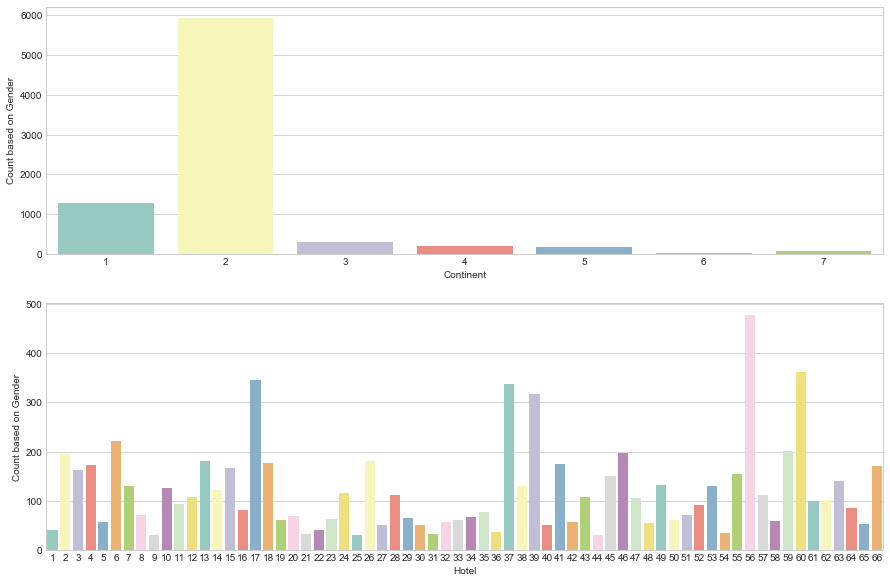

In [6]:
fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,10))

bookings_df = trip_df[trip_df["gender"] == 1] # 0:Male, 1:Female #change it if needed for analysis

# What are the most continents one gender travel from?
at=sns.countplot('continent',data=bookings_df.sort_values(by=['continent']),ax=axis1,palette="Set3")
at.set(xlabel='Continent', ylabel='Count based on Gender')


# What are the most hotel one gender travel to?
ap=sns.countplot('hotel',data=bookings_df.sort_values(by=['hotel']),ax=axis2,palette="Set3")
ap.set(xlabel='Hotel', ylabel='Count based on Gender')


#### Lets figure out the popularity of each hotel. We can see that '56' Hotel is most famous one

[<matplotlib.text.Text at 0x10591c18>, <matplotlib.text.Text at 0x10610a58>]

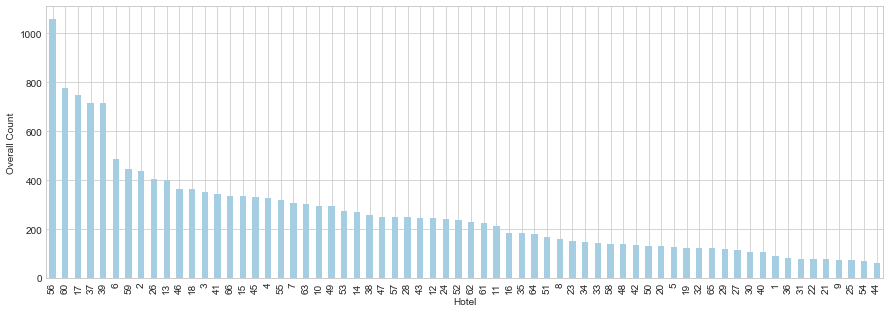

In [7]:
# lets figure out the popularity of each hotel

ax=trip_df["hotel"].value_counts().plot(kind='bar',colormap="Paired",figsize=(15,5))
ax.set(xlabel='Hotel', ylabel='Overall Count')
# We can see the 56 Hotel is most famous one

[<matplotlib.text.Text at 0x1071d0f0>, <matplotlib.text.Text at 0x110078d0>]

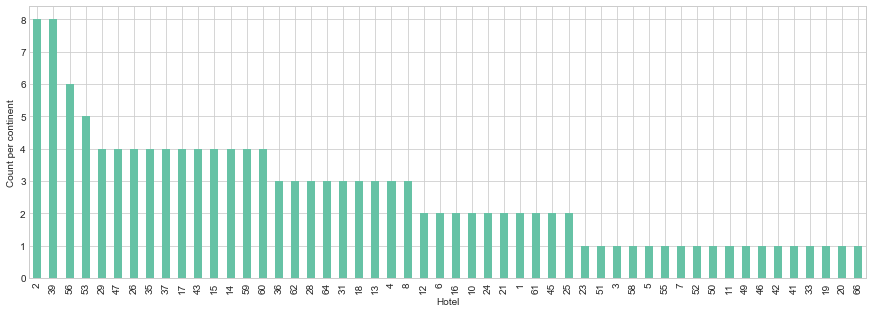

In [8]:
# Where do most of the user from a continent choose hotel?
user_cont_id = 7   # it varies from 1-7, choose any value from 1-7

fig, (axis1) = plt.subplots(1,1,figsize=(15,12))

count_users = trip_df[trip_df["continent"] == user_cont_id]
ax=count_users["hotel"].value_counts().plot(kind='bar',colormap="Set2",figsize=(15,5))
ax.set(xlabel='Hotel', ylabel='Count per continent')
### user from continent 7 travel most to hotel 2 and 39.

## Now is step of experimenting with different Approaches. After Observing Data, There are 2 approaches that can be used:

1.Machine Learning Algorithms: As Data is low in parameters, plus the data entries is also not enough, its better to go for Non-Parametric Equation as parametric one might overfit. So, We can think of KNN, Decision Trees(Random Forest, XGBOOST). Upon Experimenting with KNN, I realised that it was giving good results, if there was no constraint on repetition. But not so well for non-repetition

2.Rule Based Approach: As, we could see, gender didn't play any role in determining the famous hotels. So, One experiment to test a frequency per continent results has also been done. Where, we return the most frequent hotel, as per continent, which is not present in user's history.

We will see these approaches, and determine the best methodology on the way.

## Lets First Try Rule Based Approach. As we have discovered in visualization the most frequent hotel per continent. We will use that information here.

In [9]:
from sklearn.model_selection import train_test_split
import warnings
import operator
warnings.filterwarnings("ignore")

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
#X_train,y_train,X_test,y_test=np.array(X_train),np.array(y_train),np.array(X_test),np.array(y_test)
user_past_global={} #get the past visited hotels per user
for i in range(0,len(X_train)):
    t=X_train[i]
    if t[0] in user_past_global.keys():
        user_past_global[t[0]].append(y_train[i])
    else:
        user_past_global[t[0]]=[y_train[i]]
user_past=user_past_global
def comparelists(user,freq,top=True):
    mixture=[]
    for r in freq:
        if r in user:
            continue
        else:
            mixture.append(r)
    if top:
        return mixture[:1]
    else:
        return mixture[:5]
    
def update_user_hist(user_dict,key,value):
    if(key in user_dict.keys()):
        user_dict[key].append(value)
    else:
        user_dict[key]=[value]
        
#frequency dictionary storing order of popularity of hotels per continent    
dict_cont={1: [60, 56, 37, 17, 39, 2, 4, 26, 46, 3, 66, 6, 13, 7, 14, 59, 24, 62, 10, 45, 52, 43, 15, 61, 28, 41, 63, 53, 12, 35, 38, 55, 11, 18, 47, 8, 49, 23, 51, 57, 64, 16, 20, 65, 42, 5, 30, 27, 34, 48, 40, 29, 36, 21, 50, 19, 33, 22, 58, 32, 31, 1, 44, 25, 9, 54], 2: [56, 60, 17, 39, 37, 6, 59, 13, 2, 26, 18, 46, 41, 45, 55, 3, 66, 15, 63, 49, 7, 10, 4, 53, 57, 38, 28, 14, 47, 12, 43, 52, 24, 62, 11, 61, 16, 64, 51, 35, 33, 34, 48, 58, 50, 19, 32, 23, 8, 5, 29, 42, 20, 65, 27, 40, 30, 1, 31, 22, 9, 36, 54, 21, 44, 25], 3: [56, 41, 37, 17, 60, 4, 15, 39, 63, 2, 6, 61, 46, 18, 13, 59, 7, 38, 49, 10, 47, 57, 26, 43, 55, 45, 12, 52, 53, 16, 3, 66, 42, 32, 14, 54, 62, 24, 34, 11, 35, 50, 64, 33, 36, 51, 25, 5, 23, 28, 22, 40, 8, 9, 1, 31, 30, 20, 27, 65, 21, 29, 44, 19, 48, 58], 4: [39, 56, 60, 17, 18, 37, 6, 66, 45, 61, 52, 15, 26, 55, 4, 2, 41, 10, 38, 12, 47, 14, 59, 24, 57, 46, 49, 8, 3, 13, 28, 34, 62, 43, 25, 7, 53, 20, 11, 16, 27, 35, 19, 64, 63, 58, 33, 65, 42, 50, 51, 40, 23, 5, 30, 32, 21, 9, 22, 36, 1, 48, 54], 5: [3, 6, 56, 60, 17, 39, 37, 55, 14, 41, 2, 47, 8, 59, 23, 10, 12, 49, 13, 15, 53, 24, 63, 42, 16, 66, 45, 38, 46, 35, 11, 4, 26, 43, 18, 21, 28, 25, 9, 1, 51, 50, 29, 61, 65, 58, 40, 57, 64, 62, 27, 36, 20, 31, 30, 34, 22, 52, 54, 48, 7, 5], 6: [37, 53, 4, 17, 18, 39, 64, 60, 24, 15, 3, 6, 8, 47, 46, 23, 16, 12, 59, 19, 61, 57, 14, 11, 7, 5, 62, 9, 26, 56, 29, 30, 35, 63, 38, 41, 44, 45, 48, 49, 50, 52, 58, 54, 2], 7: [2, 39, 56, 53, 29, 47, 26, 35, 37, 17, 43, 15, 14, 59, 60, 36, 62, 28, 64, 31, 18, 13, 4, 8, 12, 6, 16, 10, 24, 21, 1, 61, 45, 25, 23, 51, 3, 58, 5, 55, 7, 52, 50, 11, 49, 46, 42, 41, 33, 19, 20, 66]}
acc=0
for i in range(0,len(X_test)):
    e=X_test[i]
    freq_h=dict_cont[e[1]]
    if e[0] in user_past.keys():
        user_h=user_past[e[0]]
    else:
        user_h=[]
    compare=comparelists(user_h,freq_h[:5],True)
    if y_test[i] in compare:
        acc+=1
        update_user_hist(user_past,e[0],y_test[i])
accuracy=acc*100.0/len(y_test)
print ("so the accuracy we obtained is %f" % accuracy)

so the accuracy we obtained is 7.580021


#### As we can see the accuracy is around 7.58% when we are only taking most common value, whereas it increases to around 22.7% when we consider top 5 Values.
###### One more Observation is that, we are able to get good accuracy, if we are not putting condition of non-repetitiveness of user.

### Now We will Explore Machine Learning Aspect of this Problem, We have used XGBoost, and RandomForest, both are Emsembles, making the accuracy of the model more accurate. Parameters of the Models have been decided via using Grid Search, it has been commented in below code, and it takes a lot of time, uncomment the crossvalidation portion to run it. 
### Also, I have used 2 methods to return the hotel which is not present in user's history. First, which only consider Machine Learning Result. Second Hybrid Method which consider Both Frequency of Hotel as per continent, and Machine Learning Result. Upon Experimenting, I wasn't able to get good results with hybrid method, and decided to go with normal Machine Learning Approach. May be we need to determine proper weightage of what needs to given to frequency and Machine Learning Result.
The Optimal Parameters have been obtained Via Cross Validation/ Grid Search Method, and predictions based on optimal parameters have been saved.
    

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import warnings
import heapq
import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
import operator
user_past_global={} #get the past visited hotels per user
for i in range(0,len(X_train)):
    t=X_train[i]
    if t[0] in user_past_global.keys():
        user_past_global[t[0]].append(y_train[i])
    else:
        user_past_global[t[0]]=[y_train[i]]
################################################### Machine Learning Method #####################################
def ML_based(pred,user,freq,Top=True):
    pre=[]
    for e in pred:
        if not(e in user):
            pre.append(e) 
    if Top:
        return pre[:1]
    else:
        #print pre
        return pre
####################################### hybrid prediction method ######################################
def ml_rule(pred,user,freq,top=True):
    pre=[]
    for e in freq:
        if not(e in user) and (e in pred):
            pre.append(e) 
    if(top):
        return pre[:1]
    else:
        return pre
def calculate_accuracy(gbm,method_name,top=True,user_past=user_past_global,X_test=X_test,y_test=y_test):
    acc=0
    for i in range(0,len(X_test)):
        d=X_test[i]
        prob_pos = gbm.predict_proba([d[1:]])
        result=heapq.nlargest(5, range(len(prob_pos[0])), key=prob_pos[0].__getitem__)
        result= [x+1 for x in result]
        freq_h=dict_cont[d[1]]
        if(d[0] in user_past.keys()):
            user_h=user_past[d[0]]
        else:
            user_h=[]
        common=method_name(result,user_h,freq_h[:5],top)
        #print common
        if y_test[i] in common:
            #update_user_hist(user_past,d[0],y_test[i])
            acc+=1
    return acc*100./len(y_test)

def crossvalidation(clf,X,y):
    # use a full grid over all parameters
    param_grid = {"max_depth": [3, None],
                  "max_features": [1, 3],
                  "min_samples_split": [2, 3, 10],
                  "min_samples_leaf": [1, 3, 10],
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}

    # run grid search
    grid_search = GridSearchCV(clf, param_grid=param_grid)
    grid_search.fit(X, y)
    print (grid_search.cv_results_['params'])
    print("GridSearchCV took for %d candidate parameter settings."
          % len(grid_search.cv_results_['params']))
 
    output=grid_search.best_params_
    return output    
#optimal=crossvalidation(clf,X_train[:,1:],y_train)

In [11]:
#uncomment below to run Random Forest
"""
clf = RandomForestClassifier(n_estimators=100,bootstrap=True,min_samples_leaf=10,min_samples_split=2,criterion='gini',max_features=3, max_depth=None)
clf=clf.fit(X_train[:,1:],y_train)
print calculate_accuracy(clf,ML_based,True)
"""

"\nclf = RandomForestClassifier(n_estimators=100,bootstrap=True,min_samples_leaf=10,min_samples_split=2,criterion='gini',max_features=3, max_depth=None)\nclf=clf.fit(X_train[:,1:],y_train)\nprint calculate_accuracy(clf,ML_based,True)\n"

### So We can see that with Random Forest, with 100 Trees, and their obtained optimal paramteres via Grid Search CV.  I have made 2 functions to get hotel predicition, 
### first one is considering only results from Random Forest Algorithm.
### second one considering the frequency of hotel too, its a mixture of hybrid.
### Observations are:
1. When we are just using 1 prediction per user, with Machine Learning Accuracy case, we are getting around 22.5% Accuracy.
2. When we are considering 5 prediction per user, with Machine Learning Accuracy case, we are getting around 62.55% Accuracy.
3. When we are considering 5 predicition per user, and top 5, with hybrid Accuracy of (considering both freq and ML result), we are getting 22.14%
4. When we are considering 1 predicition per user, and top 5, with hybrid Accuracy of (considering both freq and ML result), we are getting 11.25%. {It is returning the most frequent + predicted value}

In [12]:
"""
from tqdm import tqdm
depth=[1,2,3,5]
lr=[0.001,0.05,0.1]
max_a=0
optimal={'d':1,'lr':0.001}
for d in tqdm(depth):
    for l in lr:
        gbm = xgb.XGBClassifier(max_depth=d, n_estimators=100, learning_rate=l).fit(X_train[:,1:], y_train)
        a= calculate_accuracy(gbm,ML_based,True)
        if(a>max_a):
            optimal['d']=d
            optimal['lr']=l
            max_a=a
            print a
print optimal
print max_a # Optimal depth=3, learning rate=0.001
"""        
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.001).fit(X[:,1:],Y)

####  In Above we have used XGBoost, and tested with same hotel predicting functions. 
1. When We are using 1 prediction per user, and pure Machine Learning Prediction, we are getting around 23.25% Accuracy.
2. When We are using 5 prediction per user, and pure Machine Learning Prediction, we are getting around 62.46% Accuracy.
3. When We are using 5 prediction per user, and pure Hybrid Prediction Method, we are getting around 22.24% Accuracy.
4. When We are using 1 prediction per user, and pure Hybrid Prediction Method, we are getting around 11.22% Accuracy.

### So As we can see that Both Algorithms are providing somewhat same result, a little bit of randomness could be cause of random picking up test set. Secondly, we have observed that Best result is obtained via Machine Learning Method and when 5 cases are considered.
### This is the Case because we don't have enough features, if we would have enough features, then we could have obtained more efficient results, but as we can see, that the real output exists in top 5 predicted values.

### Finally I decided to choose XGBoost? Why XGBoost?
I chose XGBoost as it was giving better results by some points, plus, Boosting is based on weak learners (high bias, low variance). Boosting reduces error mainly by reducing bias (and to some extent variance, by aggregating the output from many models). On the other hand, Random Forest uses fully grown decision trees (low bias, high variance). It tackles the error reduction task in the opposite way: by reducing variance, and for given dataset we need to reduce bias.


Next step is to generate the results in tab-delimited file as asked. I have produced two types of output files:
1. just predicting the next hotel, which is not in user's history.
2. predicting next hotels from obtained 5 probabilistic outputs, which are not in user's history.

In [13]:
def predict_final_hotel_prediction(X,gbm,method_name=ML_based,t=True,case=True):
    result_final={}
    for i in range(0,len(X)):
            d=X[i]
            prob_pos = gbm.predict_proba([d[1:]])
            result=heapq.nlargest(10, range(len(prob_pos[0])), key=prob_pos[0].__getitem__)
            result= [x+1 for x in result]
            freq_h=dict_cont[d[1]]
            if(d[0] in user_past.keys()):
                user_h=user_past[d[0]]
            else:
                user_h=[]
            common=method_name(result,user_h,freq_h[:5],False)
            if case:
                if not (d[0] in result_final.keys()):
                    result_final[d[0]]=[common[0]]
            else:
                if not (d[0] in result_final.keys()):
                    result_final[d[0]]=common
    return result_final

In [ ]:
def write_to_tabfile(filename,maintain_count,t=2):
    with open(filename, 'wb') as f:
        writer=csv.writer(f)
        writer.writerow(['userid','hotel'])
        for k in maintain_count.keys():
            writer.writerow([k]+maintain_count[k][:t])

In [ ]:
First_type=predict_final_hotel_prediction(X,gbm)
Second_type=predict_final_hotel_prediction(X,gbm,ML_based,False,False)
write_to_tabfile('Results/output.csv',First_type) 
write_to_tabfile('Results/output2.csv',Second_type,5)